- f(model, params) ---> return: cv table, trained on the whole dataset model, ranking
- params - optimal params for the model
- same for onehot encoding
- describe importances in paper

#### No one-hot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
import json

In [2]:
data = np.load('../all_chromosomes.npy')
snp_list = np.load('../combined_SNP', allow_pickle=True)
target = np.array(np.load('../target', allow_pickle=True)) - 1 # VERY IMPORTANT
p_values = np.load('../p_values_full.npy')

In [15]:
len(p_values[p_values <= 5*10**-6])

218

In [3]:
X = data[:, np.argsort(p_values)[:30000]]
y = np.array(target)
del data

In [4]:
def f(model, params, fit_params):
    
    tables = []
    
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = model(**params)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        t = classification_report(y_test, clf.predict(X_test), output_dict=True)
        tables.append(t)
        
    clf = model(**params)
    clf.fit(X, y, **fit_params)
    
    return tables, clf

In [5]:
def get_table(tables):
    average = pd.DataFrame(tables[0])
    for df in tables[1:]:
        average += pd.DataFrame(df)
    average /= 5
    return average

## Logistic

In [6]:
params = {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 1000,
          'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'n_jobs': 4, 'verbose': 2}

tables, clf = f(LogisticRegression, 
                params,
                {})

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  8.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  8.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  7.6min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  8.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 14.7min finished


In [9]:
get_table(tables).to_csv('logreg29', index=False)

In [19]:
pd.read_csv('logreg29')

,0,1,accuracy,macro avg,weighted avg
0,0.739071,0.953231,0.931119,0.846151,0.928199
1,0.638354,0.969858,0.931119,0.804106,0.931119
2,0.677936,0.961318,0.931119,0.819627,0.928199
3,129.800000,982.400000,0.931119,1112.200000,1112.200000


In [16]:
np.save('logreg29_weights', clf.coef_[0])

## XGBClassifier

In [45]:
np.sum(y==0)/np.sum(y==1)

0.13212540716612378

In [51]:
np.sqrt(np.sum(y==0)/np.sum(y==1))

0.36349058745189505

In [46]:
tables, clf = f(XGBClassifier, 
                {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
                 'scale_pos_weight': 0.1321, 'max_depth': 8},
                {})

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:36:39] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:36:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=8
[18:36:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=8
[18:36:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[18:36:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=8
[18:36:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[18:36:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=8


/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:47] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:39:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=8
[18:39:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=8
[18:39:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[18:39:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=8
[18:40:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[18:40:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:42:54] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:42:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[18:42:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=8
[18:43:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=8
[18:43:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=8
[18:43:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=8
[18:43:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:00] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:46:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[18:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:46:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=8
[18:46:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[18:46:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[18:46:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[18:46:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:55] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:48:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[18:48:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=8
[18:49:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[18:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=8
[18:49:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[18:49:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:58] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[18:52:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[18:52:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=8
[18:52:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=8
[18:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=8
[18:52:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[18:52:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8

In [47]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.484615,0.885295,0.876819,0.684955,0.838520
recall,0.030829,0.988596,0.876819,0.509712,0.876819
f1-score,0.056977,0.934073,0.876819,0.495525,0.831709
support,129.800000,982.400000,0.876819,1112.200000,1112.200000


In [49]:
tables, clf = f(XGBClassifier, 
                {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
                 'scale_pos_weight': 0.3634, 'max_depth': 8},
                {})

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:48] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:16:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[19:16:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:16:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=8
[19:16:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=8
[19:17:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=8
[19:17:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=8
[19:17:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:19] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:20:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[19:20:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[19:20:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=8
[19:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=8
[19:20:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=8
[19:20:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:45] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:23:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=8
[19:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:23:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[19:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=8
[19:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=8
[19:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=8
[19:24:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:03] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8
[19:27:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=8
[19:27:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=8
[19:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[19:27:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=8
[19:27:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:30:01] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:30:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=8
[19:30:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[19:30:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[19:30:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=8
[19:30:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=8
[19:30:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:06] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[19:33:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=8
[19:33:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:33:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=8
[19:33:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=8
[19:33:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=8
[19:33:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=8
[19:33:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=8

In [52]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.500000,0.883922,0.882755,0.691961,0.839105
recall,0.007704,0.998371,0.882755,0.503038,0.882755
f1-score,0.015129,0.937666,0.882755,0.476398,0.830001
support,129.800000,982.400000,0.882755,1112.200000,1112.200000


In [53]:
tables, clf = f(XGBClassifier, 
                {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
                 'scale_pos_weight': 0.07, 'max_depth': 8},
                {})

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:05:54] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:06:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[21:06:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:06:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:06:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[21:06:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[21:06:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[21:06:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[21:0

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:24] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:10:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:10:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:10:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[21:10:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[21:10:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[21:10:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=8
[21:10:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=8
[21

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:14:43] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:14:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:14:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[21:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[21:14:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=8
[21:15:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:15:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=8
[21

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:19:20] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:19:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=8
[21:19:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[21:19:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=8
[21:19:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=8
[21:19:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[21:19:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:23:19] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:23:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[21:23:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[21:23:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[21:23:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=8
[21:23:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=8
[21:23:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[21

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:27:21] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:27:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=8
[21:27:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=8
[21:27:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=8
[21:27:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=8
[21:27:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=8
[21

In [54]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.440876,0.887880,0.872862,0.664378,0.835667
recall,0.064782,0.979636,0.872862,0.522209,0.872862
f1-score,0.112403,0.931418,0.872862,0.521910,0.835822
support,129.800000,982.400000,0.872862,1112.200000,1112.200000


In [55]:
tables, clf = f(XGBClassifier, 
                {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
                 'scale_pos_weight': 0.03, 'max_depth': 8},
                {})

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:39] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:35:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:35:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:35:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[21:35:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=8
[21:35:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[21:35:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[21:36:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:3

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:59] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:40:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[21:40:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:40:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[21:40:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=8
[21:40:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:40:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:40:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:4

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:43:59] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:44:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:44:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:44:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[21:44:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:44:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:44:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:44:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:4

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:47:03] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:47:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=8
[21:47:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:47:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:47:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[21:47:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[21:47:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=8
[21:47:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:4

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:49:57] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:50:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[21:50:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:50:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=8
[21:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[21:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[21:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[21:5

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:02] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[21:53:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=8
[21:53:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[21:53:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=8
[21:53:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:53:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[21:53:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[21:5

In [56]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.398858,0.893406,0.854695,0.646132,0.835640
recall,0.149612,0.947868,0.854695,0.548740,0.854695
f1-score,0.215923,0.919381,0.854695,0.567652,0.837260
support,129.800000,982.400000,0.854695,1112.200000,1112.200000


In [57]:
tables, clf = f(XGBClassifier, 
                {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
                 'scale_pos_weight': 0.01, 'max_depth': 8},
                {})

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:28] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:08:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:08:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=8
[22:08:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=8
[22:08:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:08:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:08:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:08

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:12:01] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:12:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:12:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:12:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=8
[22:12:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=8
[22:12:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:12:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:12

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:15:27] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:15:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[22:15:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[22:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[22:15:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=8
[22:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:15:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:15

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:28] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:18:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[22:18:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=8
[22:18:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:18:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[22:18:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[22:18:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=8
[22:1

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:21:15] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:21:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=8
[22:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:21:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:21:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:21:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[22:2

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:24:12] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[22:24:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[22:24:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:24:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=8
[22:24:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=8
[22:24:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=8
[22:24:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=8
[22:24:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=8
[22:2

In [58]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.307139,0.909279,0.788327,0.608209,0.838991
recall,0.390149,0.840972,0.788327,0.615561,0.788327
f1-score,0.339521,0.871824,0.788327,0.605673,0.809681
support,129.800000,982.400000,0.788327,1112.200000,1112.200000


### LightGBM

In [ ]:
# Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in 
# "binary" objective is true.
# This may cause significantly different results comparing to the previous versions of LightGBM.
# Try to set boost_from_average=false, if your old models produce bad results

# 'balanced' - only for multiclass


In [30]:
tables, clf = f(LGBMClassifier, 
                {'is_unbalance': True, 'max_depth': -1, 'n_jobs': 4, 'boost_from_average': True,
                 'importance_type': 'gain', 'random_state': 42, 'num_leaves': 31, 'verbose': 3},
                {})

In [31]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.600000,0.884165,0.881316,0.742083,0.850966
recall,0.012343,0.996131,0.881316,0.504237,0.881316
f1-score,0.024084,0.936810,0.881316,0.480447,0.830286
support,129.800000,982.400000,0.881316,1112.200000,1112.200000


In [37]:
tables, clf = f(LGBMClassifier, 
                {'scale_pos_weight': 0.116, 'max_depth': -1, 'n_jobs': 4, 'boost_from_average': True,
                 'importance_type': 'gain', 'random_state': 42, 'num_leaves': 31, 'verbose': 3},
                {})

In [38]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.571429,0.885498,0.882035,0.728463,0.848784
recall,0.026225,0.995112,0.882035,0.510669,0.882035
f1-score,0.050025,0.937103,0.882035,0.493564,0.833570
support,129.800000,982.400000,0.882035,1112.200000,1112.200000


### CatBoost

In [7]:
tables, clf = f(CatBoostClassifier, 
                {'auto_class_weights': 'Balanced', 'max_depth': 8, 'random_state': 42},
                {'verbose': 2})

Learning rate set to 0.019485
0:	learn: 0.6904471	total: 2.96ms	remaining: 2.96s
1:	learn: 0.6878691	total: 6.09ms	remaining: 3.04s
2:	learn: 0.6858840	total: 8.85ms	remaining: 2.94s
3:	learn: 0.6833804	total: 11.6ms	remaining: 2.89s
4:	learn: 0.6809083	total: 14.7ms	remaining: 2.92s
5:	learn: 0.6783979	total: 17.6ms	remaining: 2.92s
6:	learn: 0.6754425	total: 20.4ms	remaining: 2.89s
7:	learn: 0.6722411	total: 23.2ms	remaining: 2.87s
8:	learn: 0.6688379	total: 26.1ms	remaining: 2.87s
9:	learn: 0.6653567	total: 29ms	remaining: 2.87s
10:	learn: 0.6631999	total: 31.8ms	remaining: 2.86s
11:	learn: 0.6607365	total: 34.7ms	remaining: 2.86s
12:	learn: 0.6582245	total: 37.6ms	remaining: 2.85s
13:	learn: 0.6559388	total: 40.4ms	remaining: 2.84s
14:	learn: 0.6544240	total: 43.1ms	remaining: 2.83s
15:	learn: 0.6506884	total: 46.1ms	remaining: 2.83s
16:	learn: 0.6469669	total: 49ms	remaining: 2.83s
17:	learn: 0.6453997	total: 51.8ms	remaining: 2.83s
18:	learn: 0.6447931	total: 54ms	remaining: 2.79

(array([27., 14.,  9.,  8., 18.,  7.,  3.,  7.,  6.,  1.]),
 array([0.02207954, 0.31252916, 0.60297879, 0.89342841, 1.18387804,
        1.47432766, 1.76477728, 2.05522691, 2.34567653, 2.63612616,
        2.92657578]),
 <a list of 10 Patch objects>)

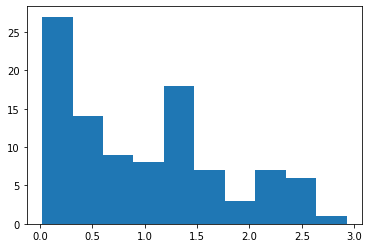

In [12]:
import matplotlib.pyplot as plt

plt.hist(clf.get_feature_importance())

In [10]:
get_table(tables)

,0,1,accuracy,macro avg,weighted avg
precision,0.428747,0.891965,0.866384,0.660356,0.837880
recall,0.117162,0.965382,0.866384,0.541272,0.866384
f1-score,0.181281,0.927036,0.866384,0.554158,0.839991
support,129.800000,982.400000,0.866384,1112.200000,1112.200000


### To tex

In [79]:
t = get_table(tables)
t

,0,1,accuracy,macro avg,weighted avg
precision,0.307139,0.909279,0.788327,0.608209,0.838991
recall,0.390149,0.840972,0.788327,0.615561,0.788327
f1-score,0.339521,0.871824,0.788327,0.605673,0.809681
support,129.800000,982.400000,0.788327,1112.200000,1112.200000


In [107]:
# 0: pr, rec, f1
# 1: pr, rec, f1
# acc
# macro avg f1
# weighted avg f1

cols = ['precision 0', 'recall 0', 'f1 0', 'precision 1', 'recall 1', 'f1 1',
        'accuracy', 'macro f1', 'weighted f1']

vals = (*t.iloc[:-1, 0], *t.iloc[:-1, 1], t.iloc[0, 2], t.iloc[2, 3], t.iloc[2, 4])

idx = ['LogReg', 'CatBoost', 'XGBoost', 'TabNet']

df = pd.DataFrame(data=[vals for _ in range(4)], columns=cols, index=idx)
df = df.round(decimals=4)
df

,precision 0,recall 0,f1 0,precision 1,recall 1,f1 1,accuracy,macro f1,weighted f1
LogReg,0.3071,0.3901,0.3395,0.9093,0.841,0.8718,0.7883,0.6057,0.8097
CatBoost,0.3071,0.3901,0.3395,0.9093,0.841,0.8718,0.7883,0.6057,0.8097
XGBoost,0.3071,0.3901,0.3395,0.9093,0.841,0.8718,0.7883,0.6057,0.8097
TabNet,0.3071,0.3901,0.3395,0.9093,0.841,0.8718,0.7883,0.6057,0.8097


In [105]:
print(df.to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  precision 0 &  recall 0 &    f1 0 &  precision 1 &  recall 1 &    f1 1 &  accuracy &  macro f1 &  weighted f1 \\
\midrule
LogReg   &       0.3071 &    0.3901 &  0.3395 &       0.9093 &     0.841 &  0.8718 &    0.7883 &    0.6057 &       0.8097 \\
CatBoost &       0.3071 &    0.3901 &  0.3395 &       0.9093 &     0.841 &  0.8718 &    0.7883 &    0.6057 &       0.8097 \\
XGBoost  &       0.3071 &    0.3901 &  0.3395 &       0.9093 &     0.841 &  0.8718 &    0.7883 &    0.6057 &       0.8097 \\
TabNet   &       0.3071 &    0.3901 &  0.3395 &       0.9093 &     0.841 &  0.8718 &    0.7883 &    0.6057 &       0.8097 \\
\bottomrule
\end{tabular}



### One-hot

In [23]:
X = X[:, :1000]

In [24]:
X.shape

(5561, 1000)

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [73]:
oh = OneHotEncoder(categories=[[0,1,2] for _ in range(X.shape[1])])

In [74]:
oh.fit(X)

OneHotEncoder(categories=[[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2],
                          [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2],
                          [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2],
                          [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2],
                          [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2],
                          [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], ...])

In [75]:
X_oh = oh.transform(X).toarray()

In [8]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pandas as pd
import json

data = np.load('../all_chromosomes.npy')
snp_list = np.load('../combined_SNP', allow_pickle=True)
target = np.array(np.load('../target', allow_pickle=True)) - 1 # VERY IMPORTANT
p_values = np.load('../p_values_full.npy')

X = data[:, np.argsort(p_values)[:10]] # CHANGE
y = np.array(target)
del data

oh = OneHotEncoder(categories=[[0,1,2] for _ in range(X.shape[1])])
oh.fit(X)
X = oh.transform(X).toarray()

def f(X, y, model, params, fit_params):
    # same function but use one hot X
    tables = []
    
    cv = StratifiedKFold(n_splits=5)
    for train_index, test_index in cv.split(X, y):
        clf = model(**params)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        t = classification_report(y_test, clf.predict(X_test), output_dict=True)
        tables.append(t)
        
    clf = model(**params)
    clf.fit(X, y, **fit_params)
    
    return tables, clf

def get_table(tables):
    average = pd.DataFrame(tables[0])
    for df in tables[1:]:
        average += pd.DataFrame(df)
    average /= 5
    return average

# LR
params = {'C': 100, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': False, 
          'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}
tables, clf = f(X, y, LogisticRegression, 
                params,
                {})
get_table(tables).to_csv('logreg29_OH', index=False)
np.save('logreg29_OH_weights', clf.coef_[0])

# XGBoost
params = {'n_jobs': 4, 'random_state': 42, 'verbosity': 3, 'importance_type': 'gain', 
          'scale_pos_weight': 0.03, 'max_depth': 8}
tables, clf = f(X, y, XGBClassifier, 
                params,
                {})
get_table(tables).to_csv('xgb29_OH', index=False)
np.save('xgb29_OH_weights', clf.feature_importances_)  # ПО ДРУГОМУ

# CB
params = {'auto_class_weights': 'Balanced', 'max_depth': 12, 'random_state': 42}
tables, clf = f(X, y, CatBoostClassifier, 
                params,
                {})
get_table(tables).to_csv('cb29_OH', index=False)
np.save('cb29_OH_weights', clf.get_feature_importance()) # ПО ДРУГОМУ

[06:50:18] ======== Monitor (0): Learner ========
[06:50:18] Configure: 0.000496s, 1 calls @ 496us

[06:50:18] ======== Monitor (0): GBTree ========
[06:50:18] ======== Monitor (0): TreePruner ========
[06:50:18] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[06:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:50:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[06:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[06:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[06:50:18] INFO: ../src/tree/u

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned no

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=8
[06:50:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned no

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=8
[06:50:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned no

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned no

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=8
[06:50:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned no

/home/stefan/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=8
[06:50:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned no

In [34]:
snp_list = np.load('../combined_SNP', allow_pickle=True)
p_values = np.load('../p_values_full.npy')

def get_table2(path):
    w = np.load(path)
    if any(w < 0): 
        w = np.abs(w)
        print('here there are some negative waits:', path)
    if 'OH' in path:
        w = np.add.reduceat(w, np.arange(0, len(w), 3))
    
    ind = np.argsort(w)[::-1]
    
    data = [(snp_list[i], w[i], p_values[i]) for i in ind]
    
    return pd.DataFrame(data, columns=['SNP', 'importance', 'p value'])

In [85]:
t = get_table2('logreg29_OH_weights.npy')
q = np.quantile(t['importance'], 0.9)

r1 = t[(t['importance'] >= q) & (t['p value'] <= 10**-4) & (t['importance'] != q)]

t = get_table2('logreg29_weights.npy')
q = np.quantile(t['importance'], 0.9)

r2 = t[(t['importance'] >= q) & (t['p value'] <= 10**-4) & (t['importance'] != q)]

t = get_table2('xgb29_OH_weights.npy')
q = np.quantile(t['importance'], 0.9)

r3 = t[(t['importance'] >= q) & (t['p value'] <= 10**-4) & (t['importance'] != q)]


t2 = pd.DataFrame([(snp_list[i], p_values[i]) for i in range(len(snp_list))], columns=['snp', 'p value'])
t1 = pd.read_csv('../importances_17000')

t = pd.merge(t1, t2)
q = np.quantile(t['importance'], 0.99)
r4 = t[(t['importance'] >= q) & (t['p value'] <= 10**-4) & (t['importance'] != q)]



print(set(r1['SNP']) | set(r3['SNP']) | set(r3['SNP']) | set(r4['snp']))

here there are some negative waits: logreg29_OH_weights.npy
here there are some negative waits: logreg29_weights.npy
{'rs1047912_A', 'rs4926844_A', 'rs7790918_G', 'rs7570971_A', 'rs6740877_A', 'rs736647_G', 'rs10496984_A', 'rs12203592_A', 'rs10515941_A', 'rs17206256_A', 'rs9907544_G', 'rs710824_A', 'rs1204875_A', 'rs9792096_G', 'rs565627_C', 'rs9967_G', 'rs1838075_C', 'rs12029258_A', 'rs2273195_A', 'rs4323689_A', 'rs6546345_G', 'rs12033025_A', 'rs7567409_A', 'rs11104326_A'}


In [84]:
t2 = pd.DataFrame([(snp_list[i], p_values[i]) for i in range(len(snp_list))], columns=['snp', 'p value'])
t1 = pd.read_csv('../importances_17000')

t = pd.merge(t1, t2)

q = np.quantile(t['importance'], 0.99)

r = t[(t['importance'] >= q) & (t['p value'] <= 10**-4) & (t['importance'] != q)]

print(set(r['snp']))

{'rs710824_A', 'rs1047912_A', 'rs7790918_G', 'rs7570971_A', 'rs17206256_A', 'rs6740877_A', 'rs9792096_G', 'rs565627_C', 'rs10496984_A', 'rs9967_G', 'rs736647_G', 'rs1838075_C', 'rs10515941_A', 'rs12203592_A', 'rs6546345_G', 'rs9907544_G', 'rs7567409_A', 'rs11104326_A'}


In [79]:
t = pd.read_csv('../importances_17000')

t['p value'] = 

,Unnamed: 0,snp,importance
0,0,rs12415857_A,0.061263
1,1,rs11169335_G,0.044157
2,2,rs710141_T,0.032410
3,3,rs710824_A,0.031750
4,4,rs1702003_A,0.026717
...,...,...,...
16995,16995,rs12610292_A,0.000000
16996,16996,rs4853638_C,0.000000
16997,16997,rs662196_G,0.000000
16998,16998,rs9941087_A,0.000000


In [38]:
get_table2('logreg29_weights.npy').head(n=10)

here there are some negative waits: logreg29_weights.npy


,SNP,importance,p value
0,rs11586980_A,0.036013,0.414390
1,rs10753368_A,0.034542,0.398653
2,rs4370753_A,0.033665,0.033377
3,rs643382_A,0.032961,0.598375
4,rs686546_A,0.032597,0.989961
5,rs4654487_A,0.032466,0.700722
6,rs2301472_A,0.032438,0.085182
7,rs4648888_G,0.032293,0.852258
8,rs1848185_A,0.032231,0.720853
9,rs11805709_A,0.032112,0.290406


## Plots

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
snp_list = np.load('../combined_SNP', allow_pickle=True)
p_values = np.load('../p_values_full.npy')
snp_list = [snp_list[i] for i in np.argsort(p_values)[:30000]]
p_values = p_values[np.argsort(p_values)[:30000]]

wlr = np.load('logreg29_OH_weights.npy')
wlr = np.abs(wlr)
wlr = np.add.reduceat(wlr, np.arange(0, len(wlr), 3))

wxgb = np.load('xgb29_OH_weights.npy')
wxgb = np.abs(wxgb)
wxgb = np.add.reduceat(wxgb, np.arange(0, len(wxgb), 3))

t2 = pd.DataFrame([(snp_list[i], p_values[i]) for i in range(len(snp_list))], columns=['snp', 'p value'])
t1 = pd.read_csv('../importances_17000')
t = pd.merge(t1, t2)
t['log p value'] = -np.log10(t['p value'])

In [47]:
df = pd.DataFrame({'snp': snp_list, 'lr': wlr, 'xgb': wxgb})
m = pd.merge(t[['snp', 'importance', 'log p value']], df)
m = m[(m['importance'] != 0) & (m['xgb'] != 0)]
m

,snp,importance,log p value,lr,xgb
3,rs710824_A,3.174994e-02,5.689366,0.051726,0.000594
36,rs9907544_G,3.946068e-03,4.708709,0.047235,0.002198
58,rs3794678_G,2.606853e-03,2.545541,0.023354,0.000565
101,rs17489732_A,1.606836e-03,2.524878,0.018459,0.002961
137,rs865410_C,1.141625e-03,2.715062,0.029193,0.000116
...,...,...,...,...,...
6328,rs6764816_C,6.382962e-09,4.000626,0.034065,0.000078
6337,rs4985682_G,5.781084e-09,3.964962,0.063417,0.000619
6351,rs9538335_A,3.951587e-09,3.435800,0.049108,0.000690
6374,rs11768083_A,2.116429e-09,3.409954,0.021247,0.000395


In [51]:
tuples = list(m.itertuples(index=False, name=None))

In [55]:
# Paretto Points
optimal = []
n = len(tuples)
for i in range(n):
    p = tuples[i]
    flag = True
    for j in range(n):
        q = tuples[j]
        if i != j and q[1] > p[1] and q[2] > p[2] and q[3] > p[3] and q[4] > p[4]:
            flag = False
            break
    if flag:
        optimal.append(p)

In [79]:
pd.DataFrame({'SNP': [p[0] for p in optimal]}).to_csv('paretto_optimal.csv', index=False)

In [84]:
pd.DataFrame({'SNP': [p[0] for p in optimal if p[2] > 5]}).to_csv('paretto_optimal_filtered.csv', index=False)

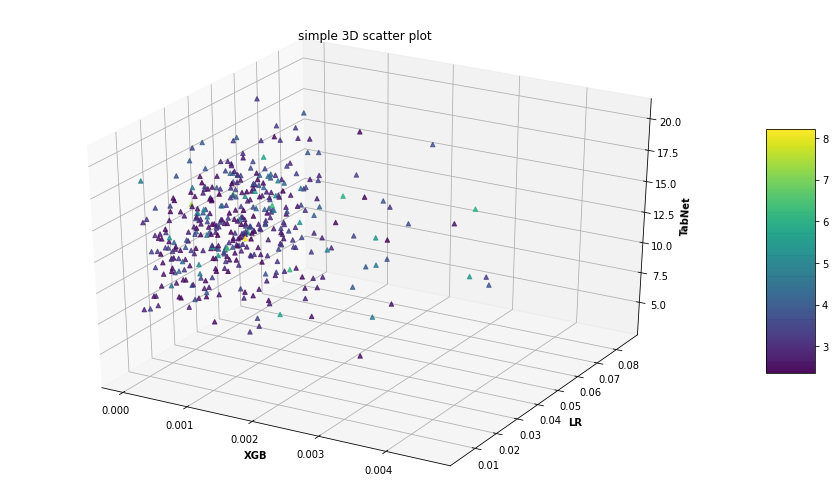

In [72]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

my_cmap = plt.get_cmap('viridis')
 
sctt = ax.scatter3D(list(m['xgb']), list(m['lr']), list(-np.log(m['importance'])),
                    alpha = 0.8,
                    c = m['log p value'],
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('XGB', fontweight ='bold')
ax.set_ylabel('LR', fontweight ='bold')
ax.set_zlabel('TabNet', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()

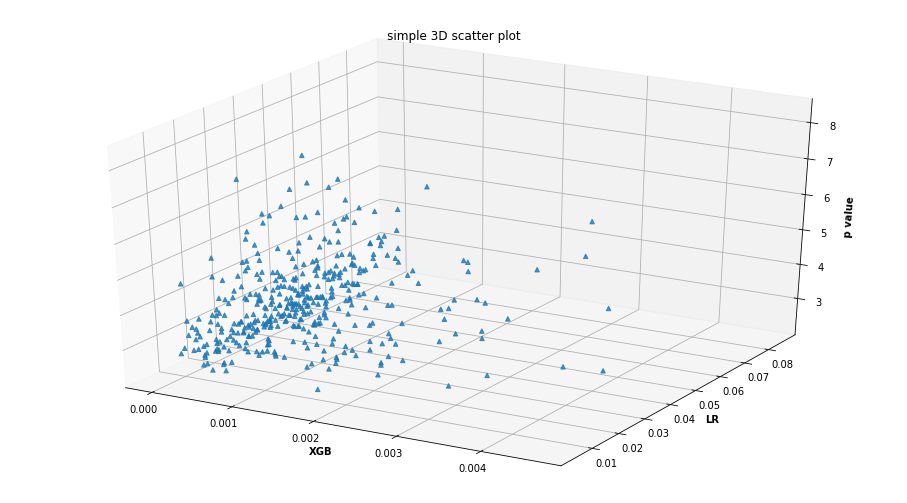

In [65]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
sctt = ax.scatter3D(list(m['xgb']), list(m['lr']), list(m['log p value']),
                    alpha = 0.8,
                    marker ='^')
 
plt.title("simple 3D scatter plot")
ax.set_xlabel('XGB', fontweight ='bold')
ax.set_ylabel('LR', fontweight ='bold')
ax.set_zlabel('p value', fontweight ='bold')
 
# show plot
plt.show()

### LR

In [85]:
snp_list = np.load('../combined_SNP', allow_pickle=True)
p_values = np.load('../p_values_full.npy')
snp_list = [snp_list[i] for i in np.argsort(p_values)[:30000]]
p_values = p_values[np.argsort(p_values)[:30000]]

w = np.load('logreg29_OH_weights.npy')
w = np.abs(w)
w = np.add.reduceat(w, np.arange(0, len(w), 3))

In [86]:
# top 10
df = pd.DataFrame({'SNP': snp_list,
                   'LR importance': w,
                   'p value': p_values}).sort_values(by='LR importance',
                                                     ascending=False,
                                                     ignore_index=True).head(n=10)
df['SNP'] = df['SNP'].apply(lambda x: x.split('_')[0])
print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
        SNP &  LR importance &       p value \\
\midrule
  rs2819493 &       0.108309 &  9.106304e-10 \\
  rs2248665 &       0.096612 &  1.312453e-03 \\
  rs2575911 &       0.093755 &  7.262425e-03 \\
 rs10178148 &       0.093735 &  1.128915e-03 \\
  rs7533470 &       0.091907 &  8.885136e-06 \\
  rs7803158 &       0.091191 &  2.291742e-05 \\
  rs1451805 &       0.090259 &  1.643522e-03 \\
  rs6510492 &       0.088417 &  5.309916e-04 \\
  rs1547588 &       0.087401 &  1.300521e-03 \\
   rs474186 &       0.086089 &  1.829948e-03 \\
\bottomrule
\end{tabular}



In [88]:
df.to_csv('LR_top10.csv', index=False)

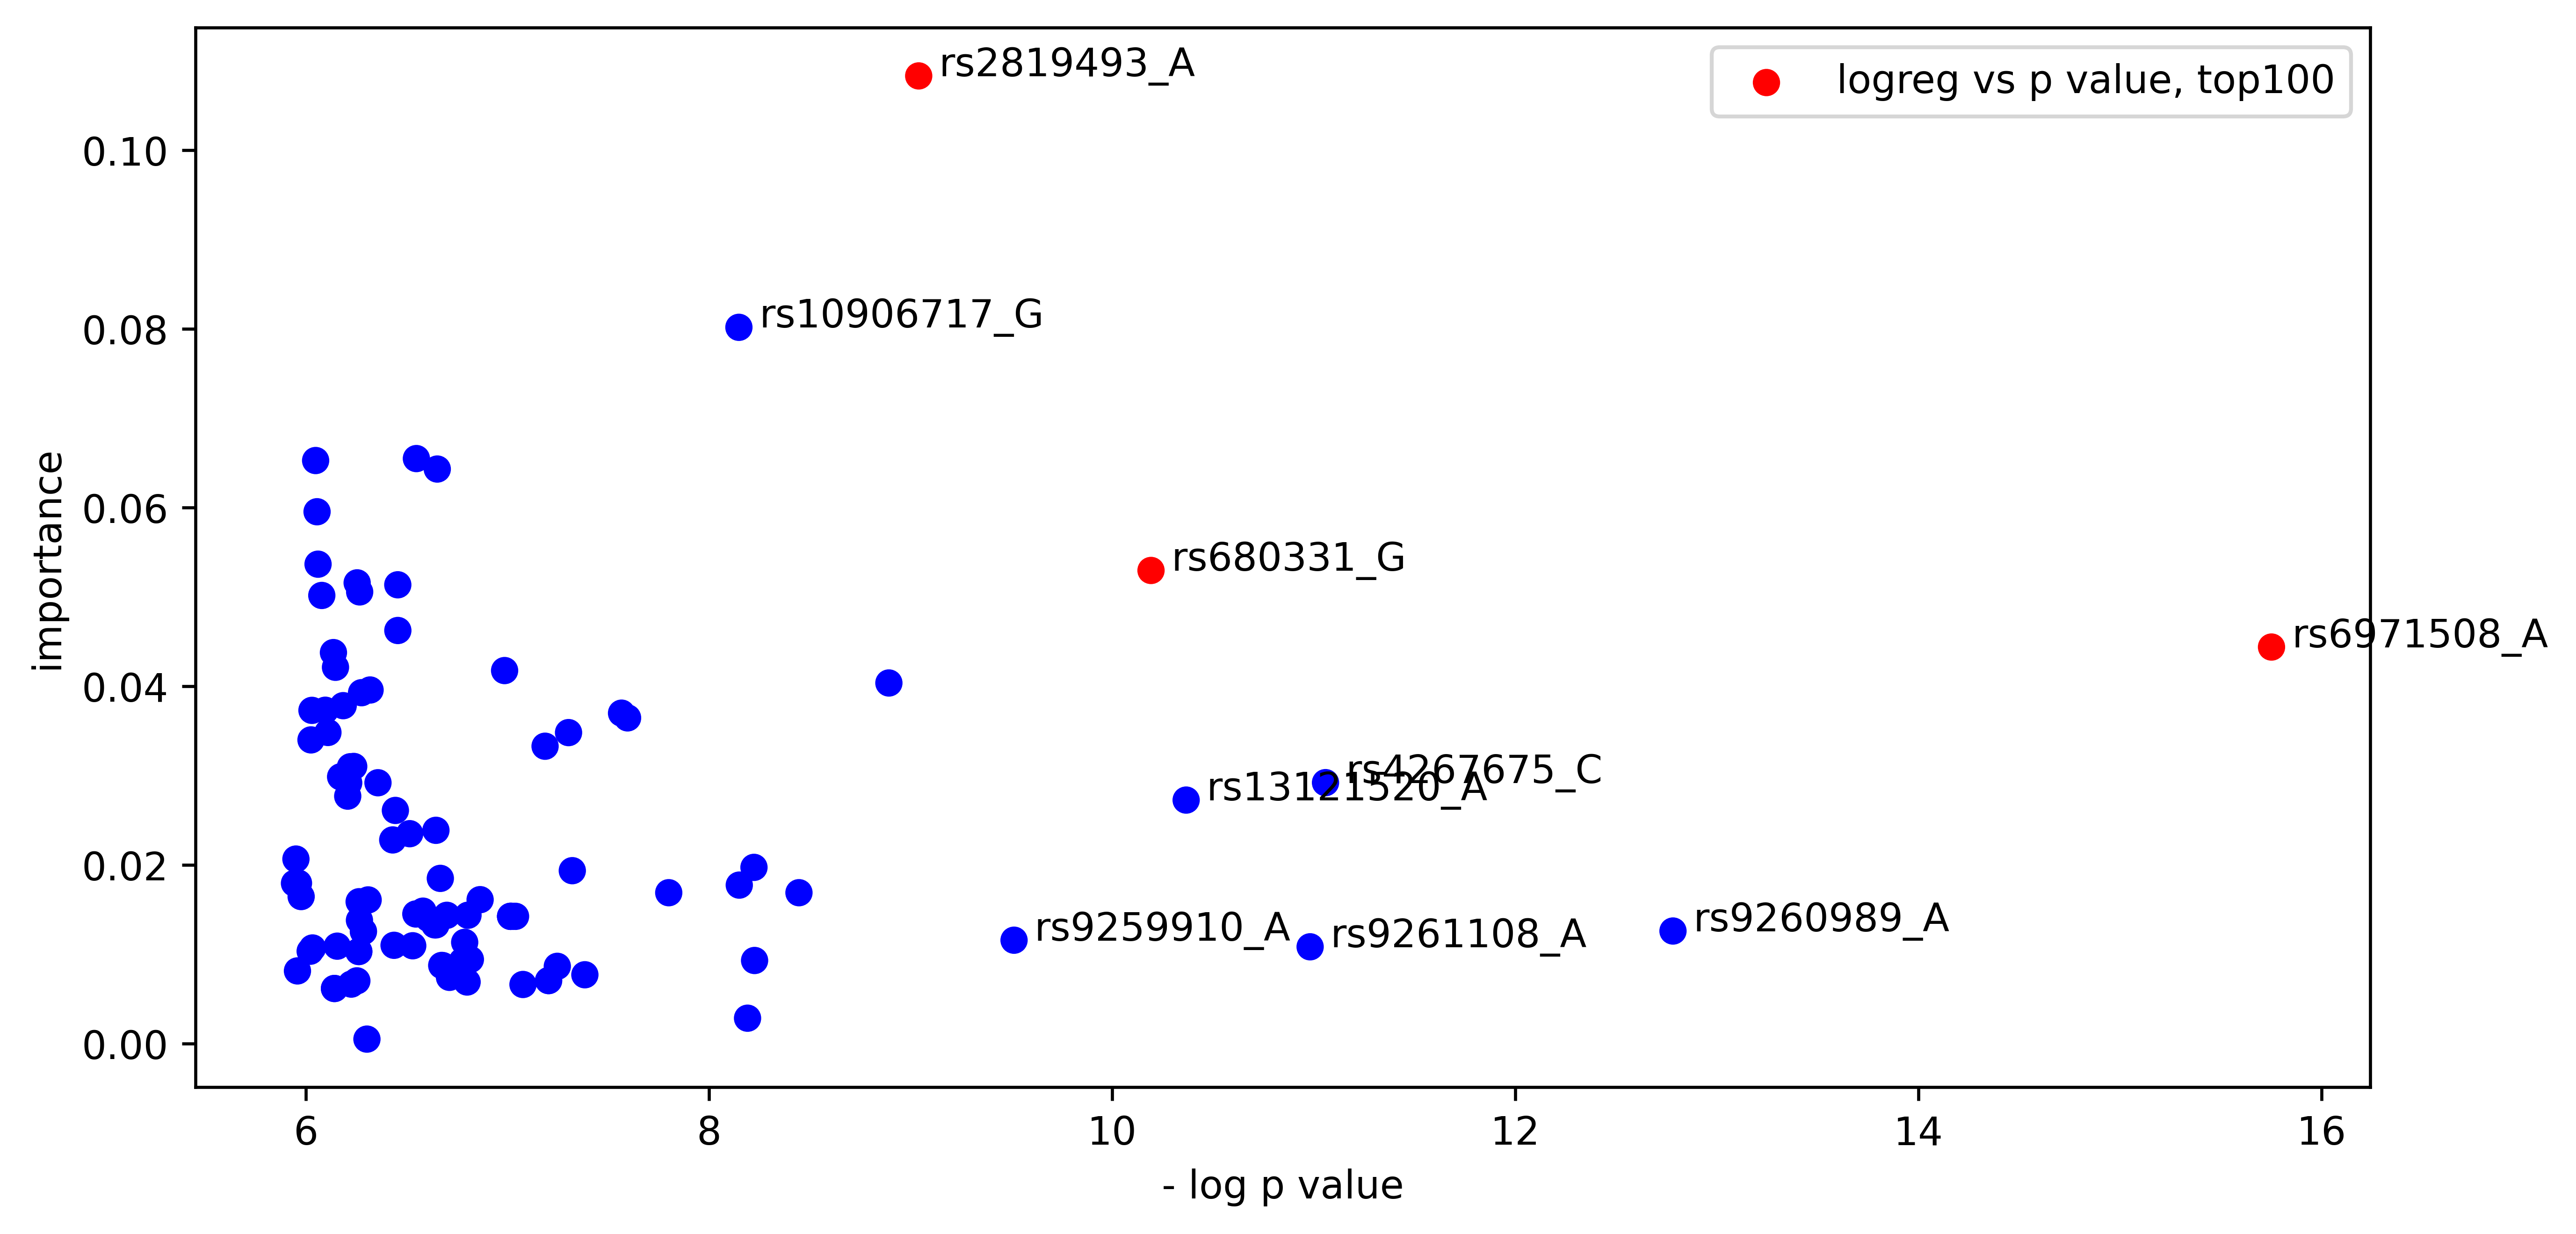

In [5]:
plt.figure(figsize=(10, 5), dpi=600)
x, y = -np.log10(p_values)[:100], w[:100]

color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'

plt.scatter(x, y, color=color, label='logreg vs p value, top100')
for i in range(100):
    if x[i] >= 9 or y[i] >= 0.07:
        plt.annotate(snp_list[i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

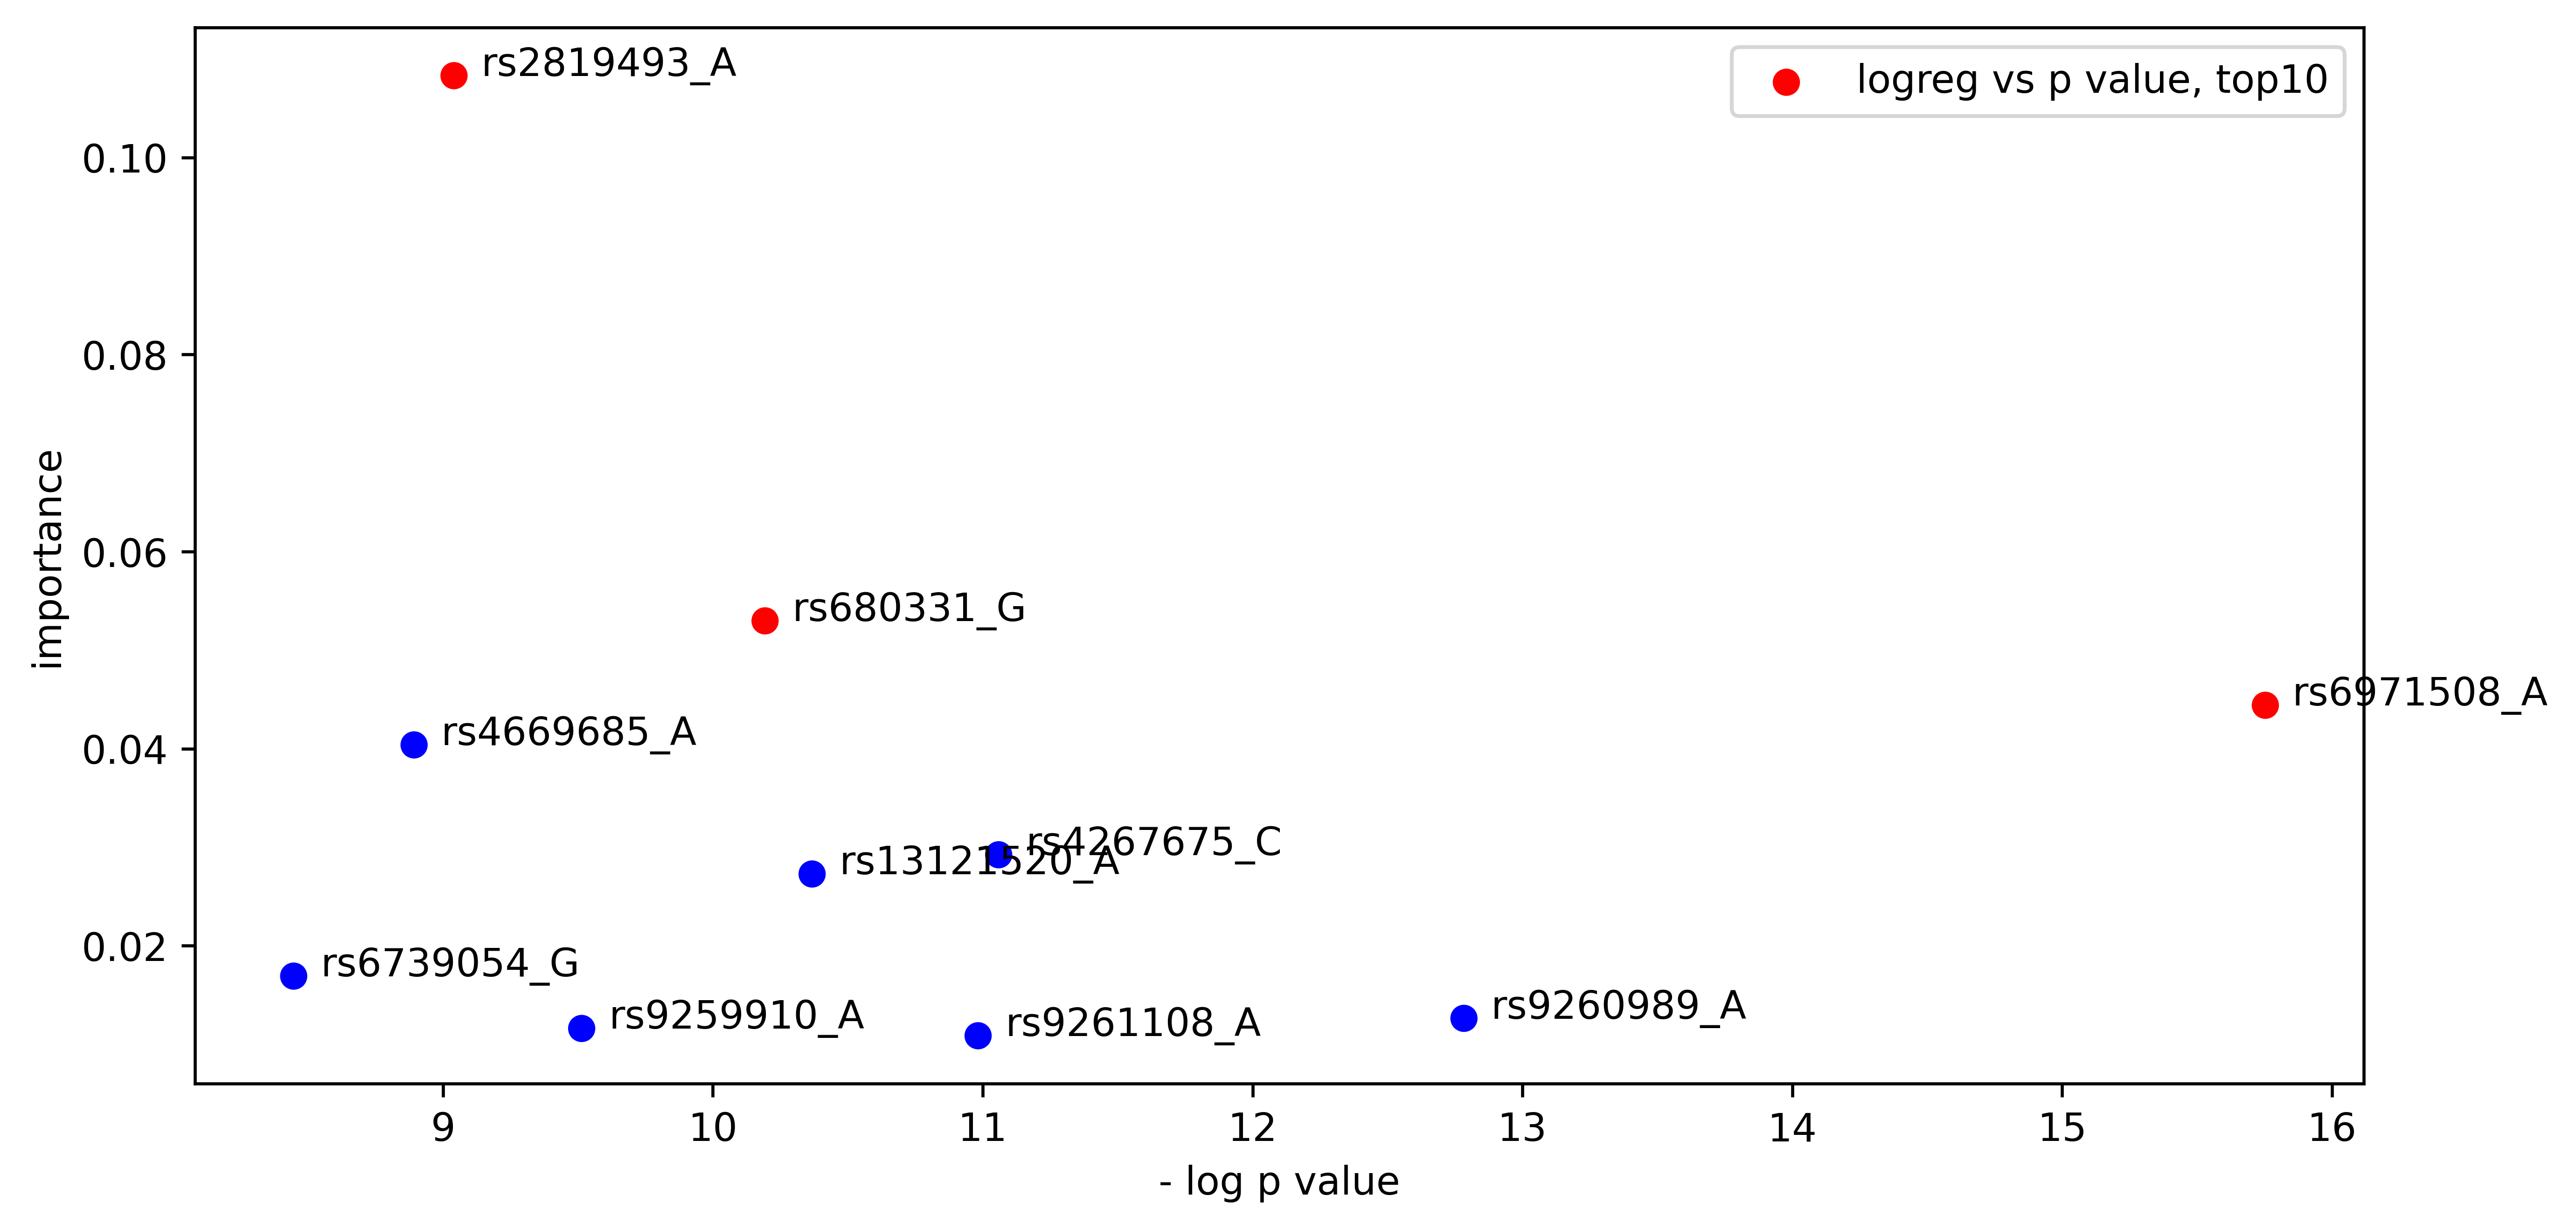

In [6]:
plt.figure(figsize=(10, 5), dpi=600)
x, y = -np.log10(p_values)[:10], w[:10]

color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'

plt.scatter(x, y, color=color, label='logreg vs p value, top10')
for i in range(10):
    plt.annotate(snp_list[i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

### XGB

In [89]:
snp_list = np.load('../combined_SNP', allow_pickle=True)
p_values = np.load('../p_values_full.npy')
snp_list = [snp_list[i] for i in np.argsort(p_values)[:30000]]
p_values = p_values[np.argsort(p_values)[:30000]]

w = np.load('xgb29_OH_weights.npy')
w = np.abs(w)
w = np.add.reduceat(w, np.arange(0, len(w), 3))

In [90]:
# top 10
df = pd.DataFrame({'SNP': snp_list,
                   'XGB importance': w,
                   'p value': p_values}).sort_values(by='XGB importance',
                                                     ascending=False,
                                                     ignore_index=True).head(n=10)
df['SNP'] = df['SNP'].apply(lambda x: x.split('_')[0])
print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
        SNP &  XGB importance &       p value \\
\midrule
 rs10493880 &        0.004747 &  4.015932e-03 \\
 rs12592594 &        0.004639 &  2.714991e-08 \\
   rs269791 &        0.004601 &  4.011083e-04 \\
   rs471716 &        0.004560 &  4.970841e-03 \\
  rs2697800 &        0.004530 &  4.152973e-03 \\
   rs739699 &        0.004217 &  6.317823e-04 \\
 rs12144807 &        0.004039 &  2.103771e-04 \\
  rs2094372 &        0.004034 &  4.470859e-04 \\
 rs10036598 &        0.004003 &  1.043013e-03 \\
  rs2610015 &        0.003952 &  5.188031e-06 \\
\bottomrule
\end{tabular}



In [91]:
df.to_csv('XGB_top10.csv', index=False)

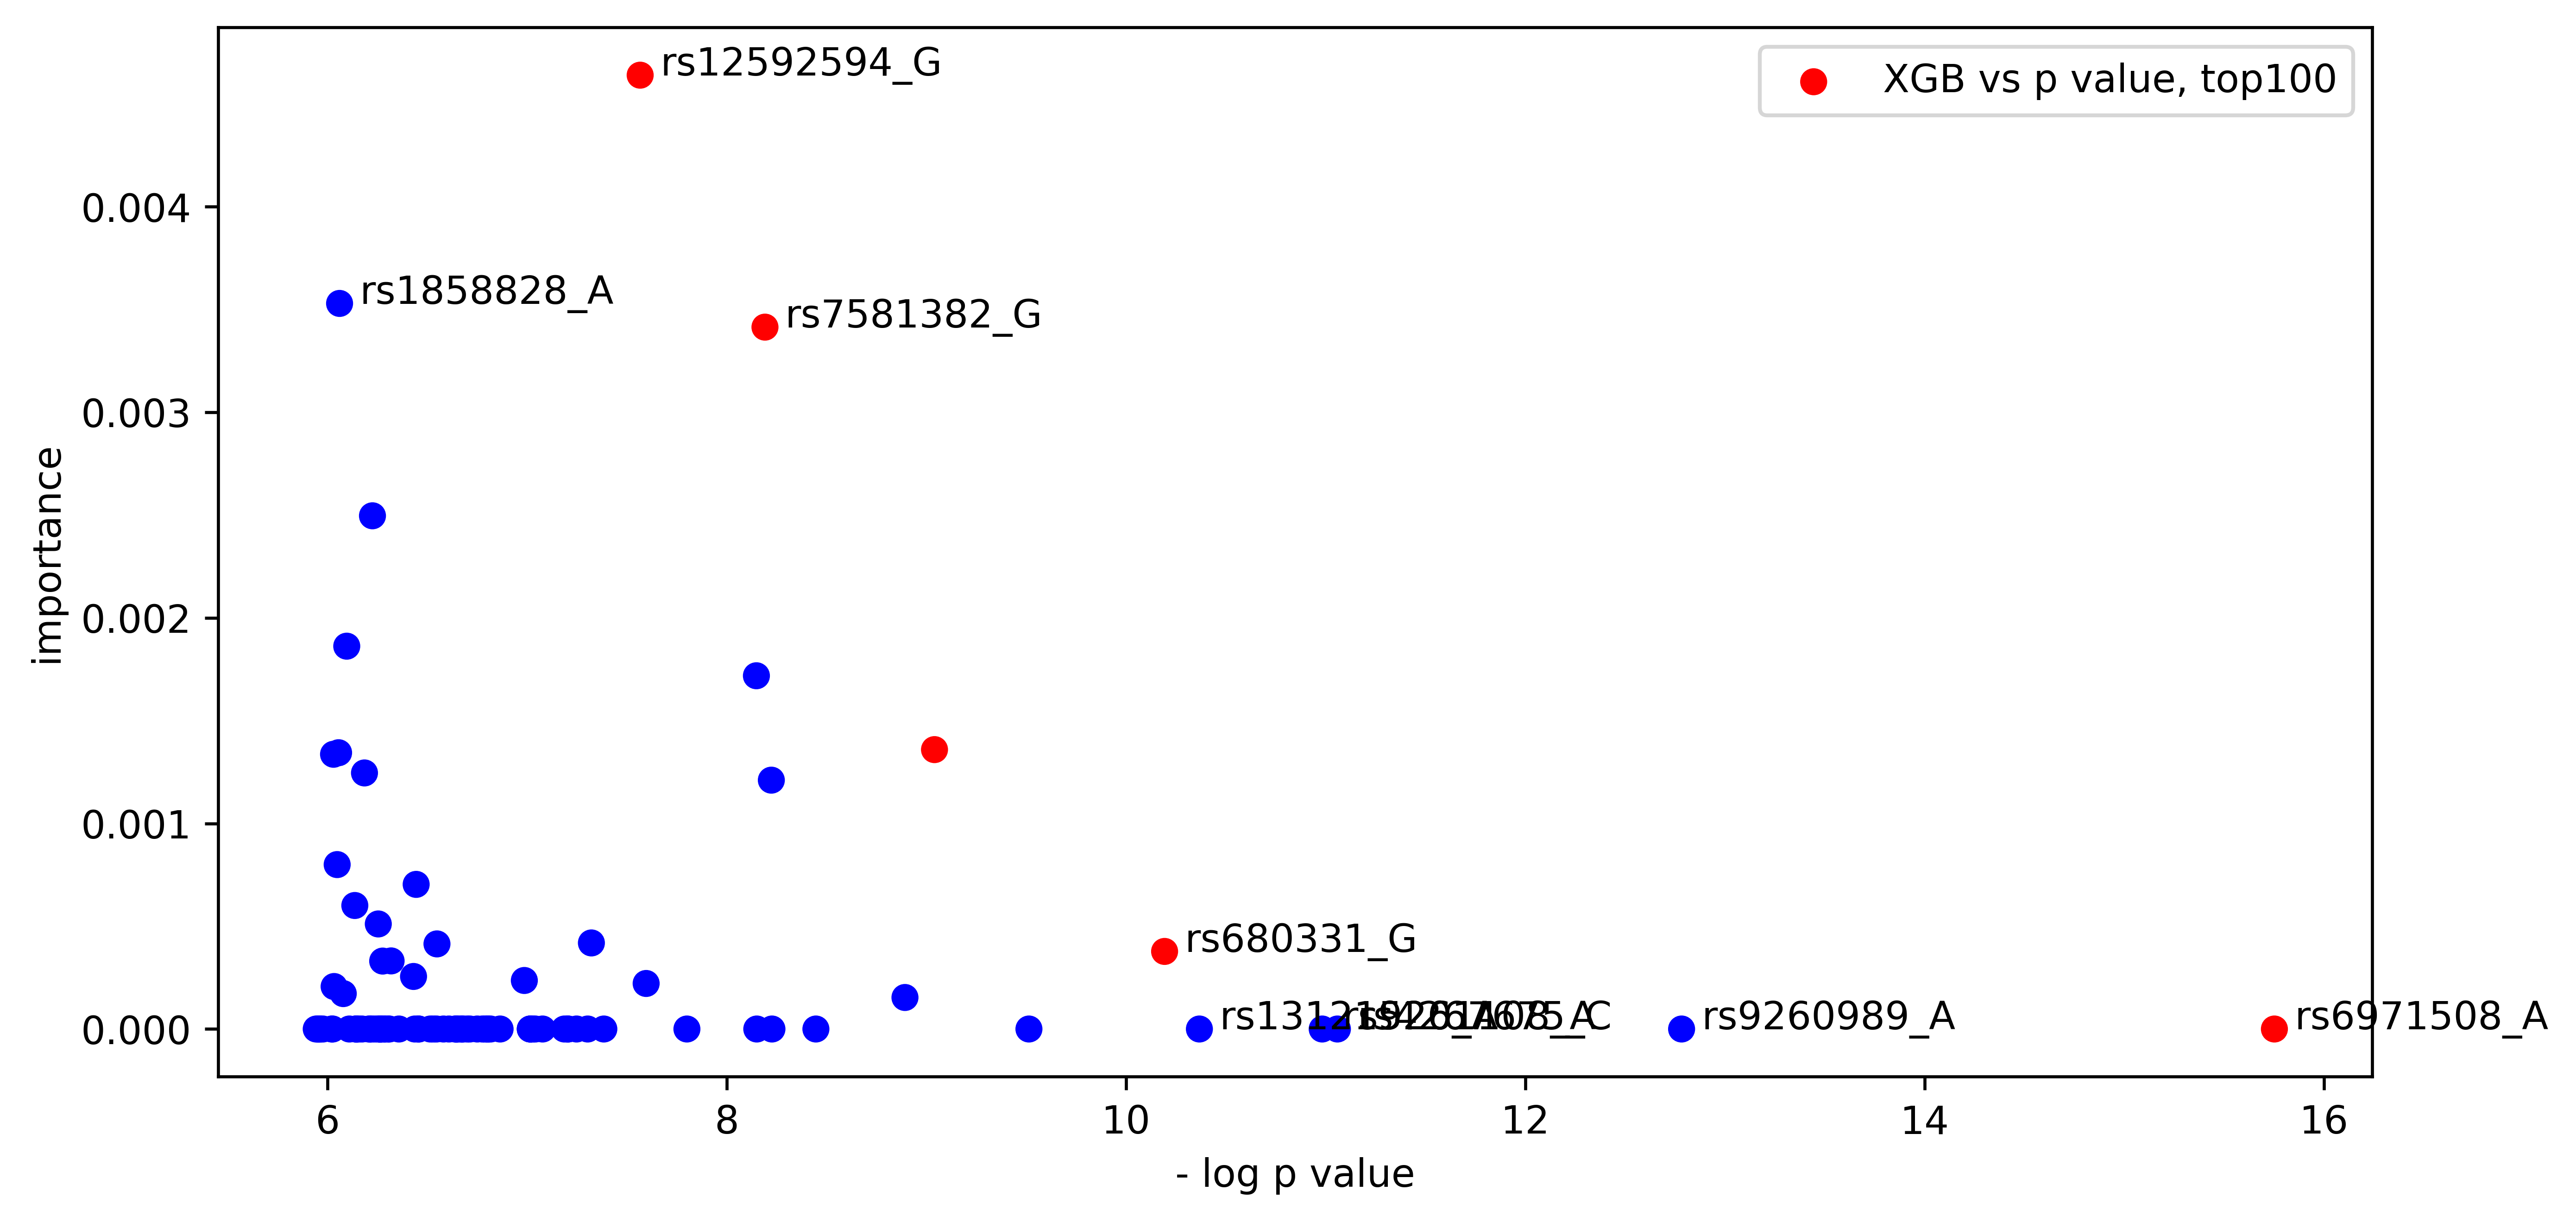

In [9]:
plt.figure(figsize=(10, 5), dpi=600)
x, y = -np.log10(p_values)[:100], w[:100]
color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'
plt.scatter(x, y, color=color, label='XGB vs p value, top100')
for i in range(100):
    if x[i] >= 10 or y[i] >= 0.0025:
        plt.annotate(snp_list[i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

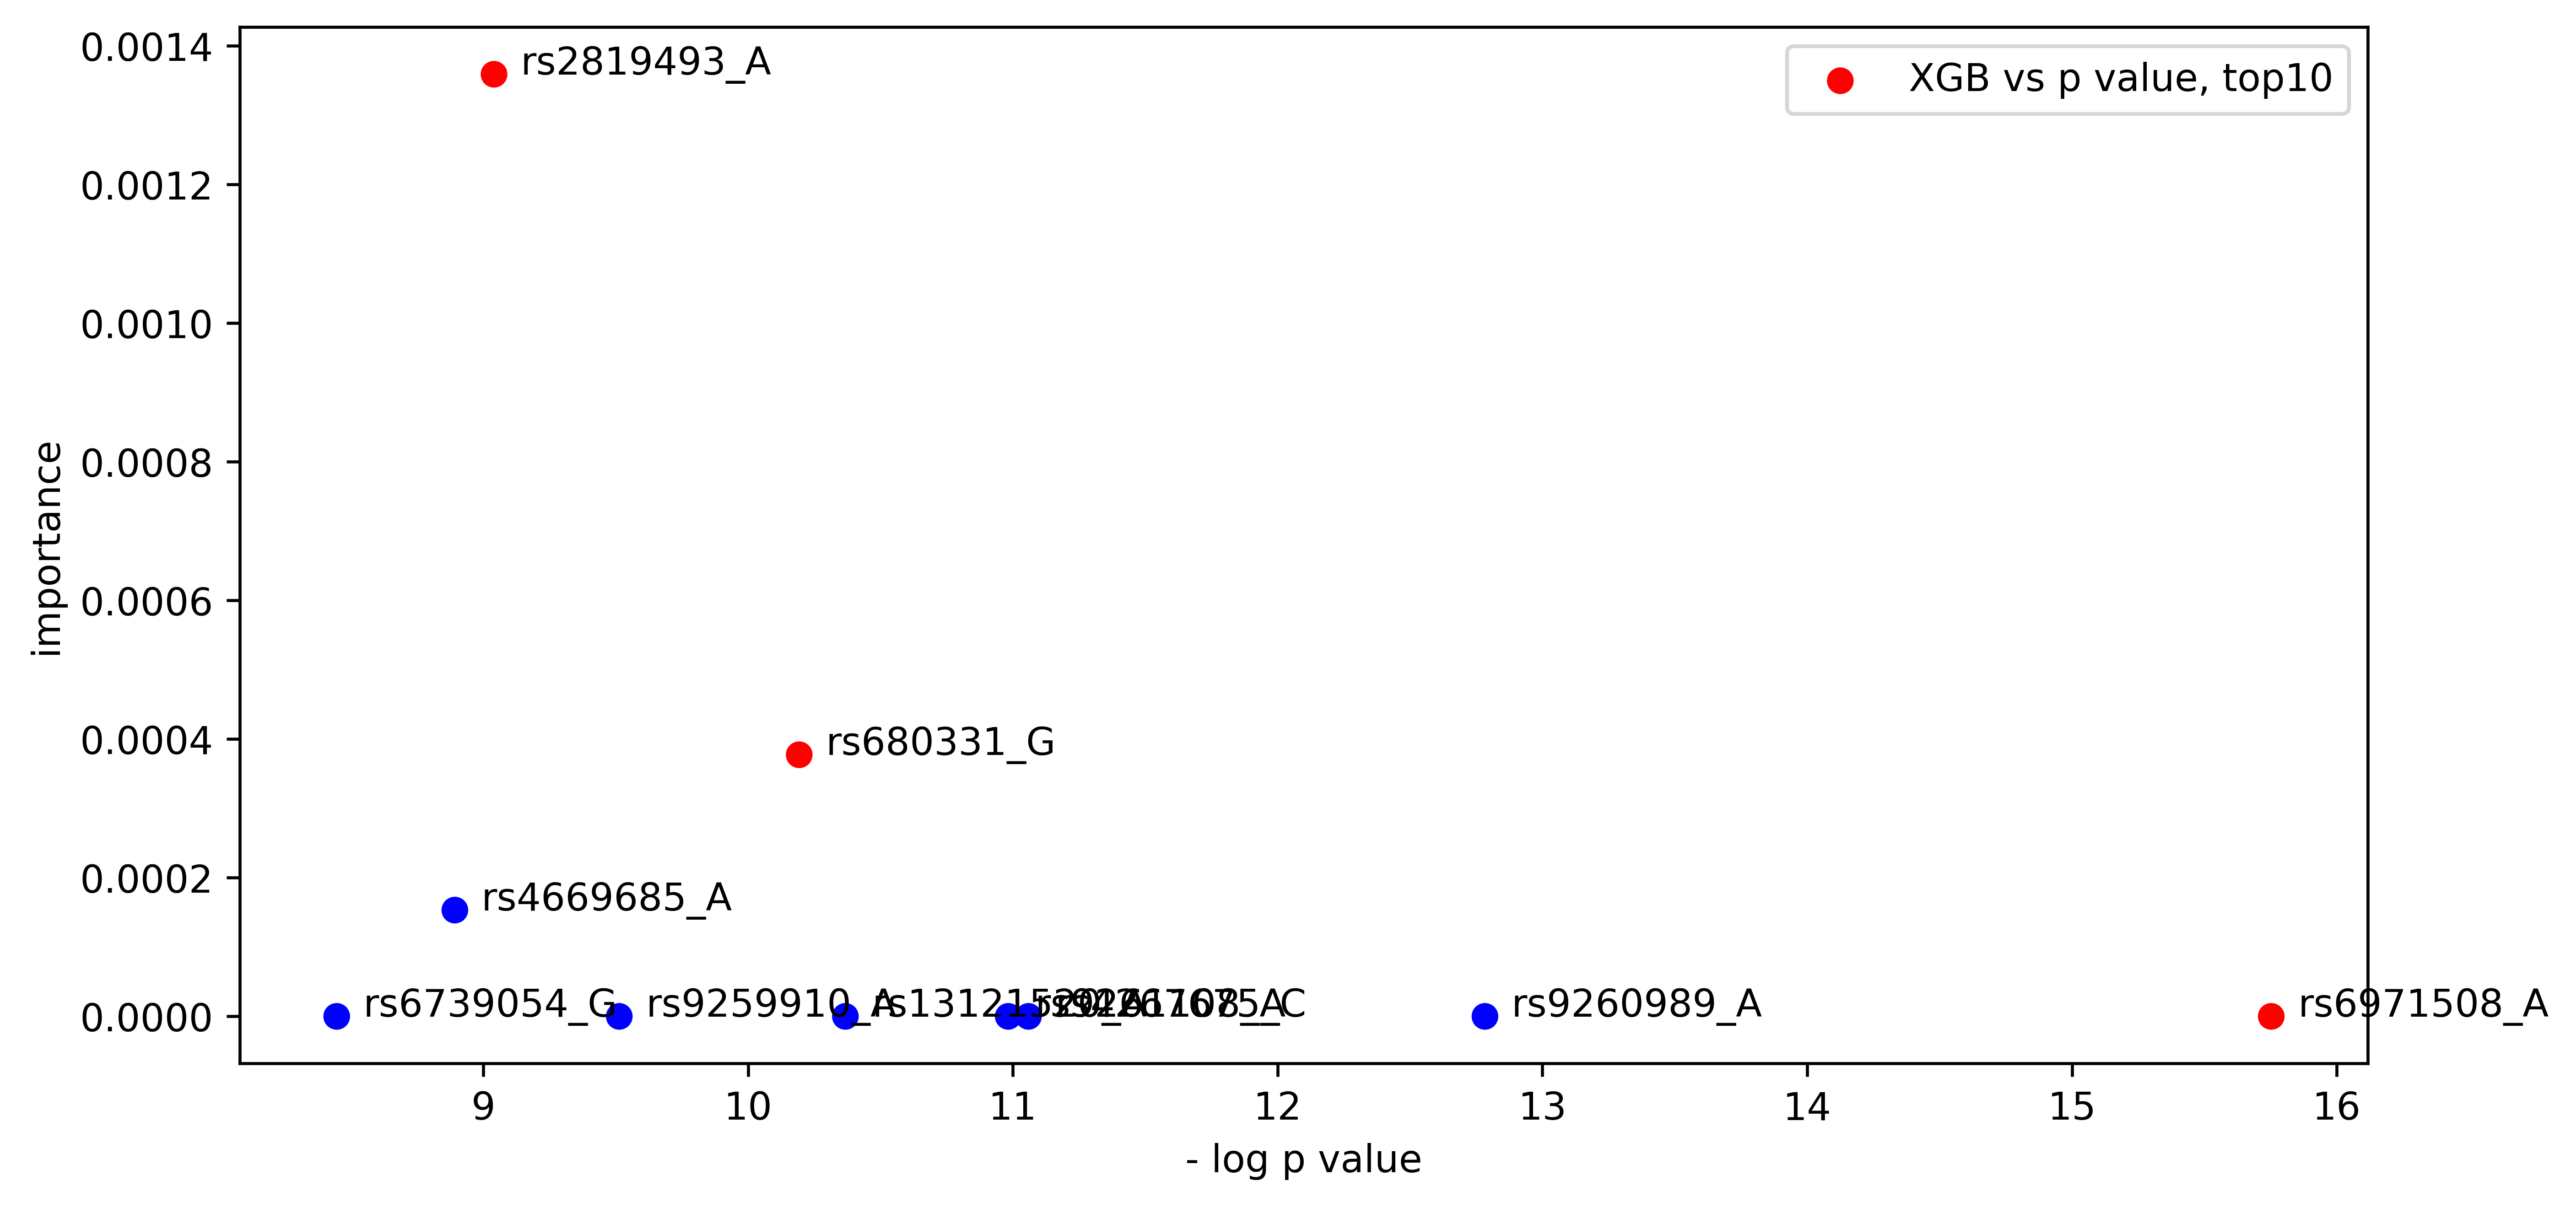

In [10]:
plt.figure(figsize=(10, 5), dpi=600)
x, y = -np.log10(p_values)[:10], w[:10]

color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'

plt.scatter(x, y, color=color, label='XGB vs p value, top10')
for i in range(10):
    plt.annotate(snp_list[i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

## TabNet

In [92]:
snp_list = np.load('../combined_SNP', allow_pickle=True)
p_values = np.load('../p_values_full.npy')
snp_list = [snp_list[i] for i in np.argsort(p_values)[:30000]]
p_values = p_values[np.argsort(p_values)[:30000]]

t2 = pd.DataFrame([(snp_list[i], p_values[i]) for i in range(len(snp_list))], columns=['snp', 'p value'])
t1 = pd.read_csv('../importances_17000')
t = pd.merge(t1, t2)
t['log p value'] = -np.log10(t['p value'])

In [97]:
t.sort_values(by='importance', ascending=False).head(n=10)[['snp', 'importance', 'p value']].to_csv('TabNet_top10.csv', index=False)

In [18]:
t.sort_values(by='p value')[t['importance'] != 0][:100]

/home/stefan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,snp,importance,p value,log p value
4311,4311,rs4267675_C,1.220617e-06,8.729802e-12,11.058996
2259,2259,rs6739054_G,1.237147e-05,3.576594e-09,8.446530
4520,4520,rs7193174_A,9.695190e-07,5.979829e-09,8.223311
5756,5756,rs13072547_A,1.419773e-07,4.764969e-08,7.321940
995,995,rs16914113_G,7.750829e-05,6.246707e-08,7.204349
...,...,...,...,...,...
2382,2382,rs4931248_C,1.072335e-05,6.810135e-06,5.166844
4951,4951,rs1474870_A,5.523213e-07,6.846354e-06,5.164541
3341,3341,rs4448101_G,3.665635e-06,7.185594e-06,5.143537
2863,2863,rs357260_G,6.288350e-06,7.318324e-06,5.135588


In [19]:
# top 10
df = pd.DataFrame(t.sort_values(by='importance', 
                               ascending=False, 
                               ignore_index=True)[['snp', 'importance', 'p value']].head(n=10))
df.rename(columns={'snp': 'SNP', 'importance': 'TabNet importance'}, inplace=True)
df['SNP'] = df['SNP'].apply(lambda x: x.split('_')[0])
print(df.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
        SNP &  TabNet importance &   p value \\
\midrule
 rs12415857 &           0.061263 &  0.000375 \\
 rs11169335 &           0.044157 &  0.000309 \\
   rs710141 &           0.032410 &  0.002142 \\
   rs710824 &           0.031750 &  0.000002 \\
  rs1702003 &           0.026717 &  0.000787 \\
  rs1499172 &           0.025958 &  0.004148 \\
  rs9792096 &           0.022899 &  0.000007 \\
  rs1223471 &           0.017404 &  0.002997 \\
  rs4255154 &           0.014837 &  0.004317 \\
  rs7819465 &           0.014781 &  0.000183 \\
\bottomrule
\end{tabular}



/home/stefan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


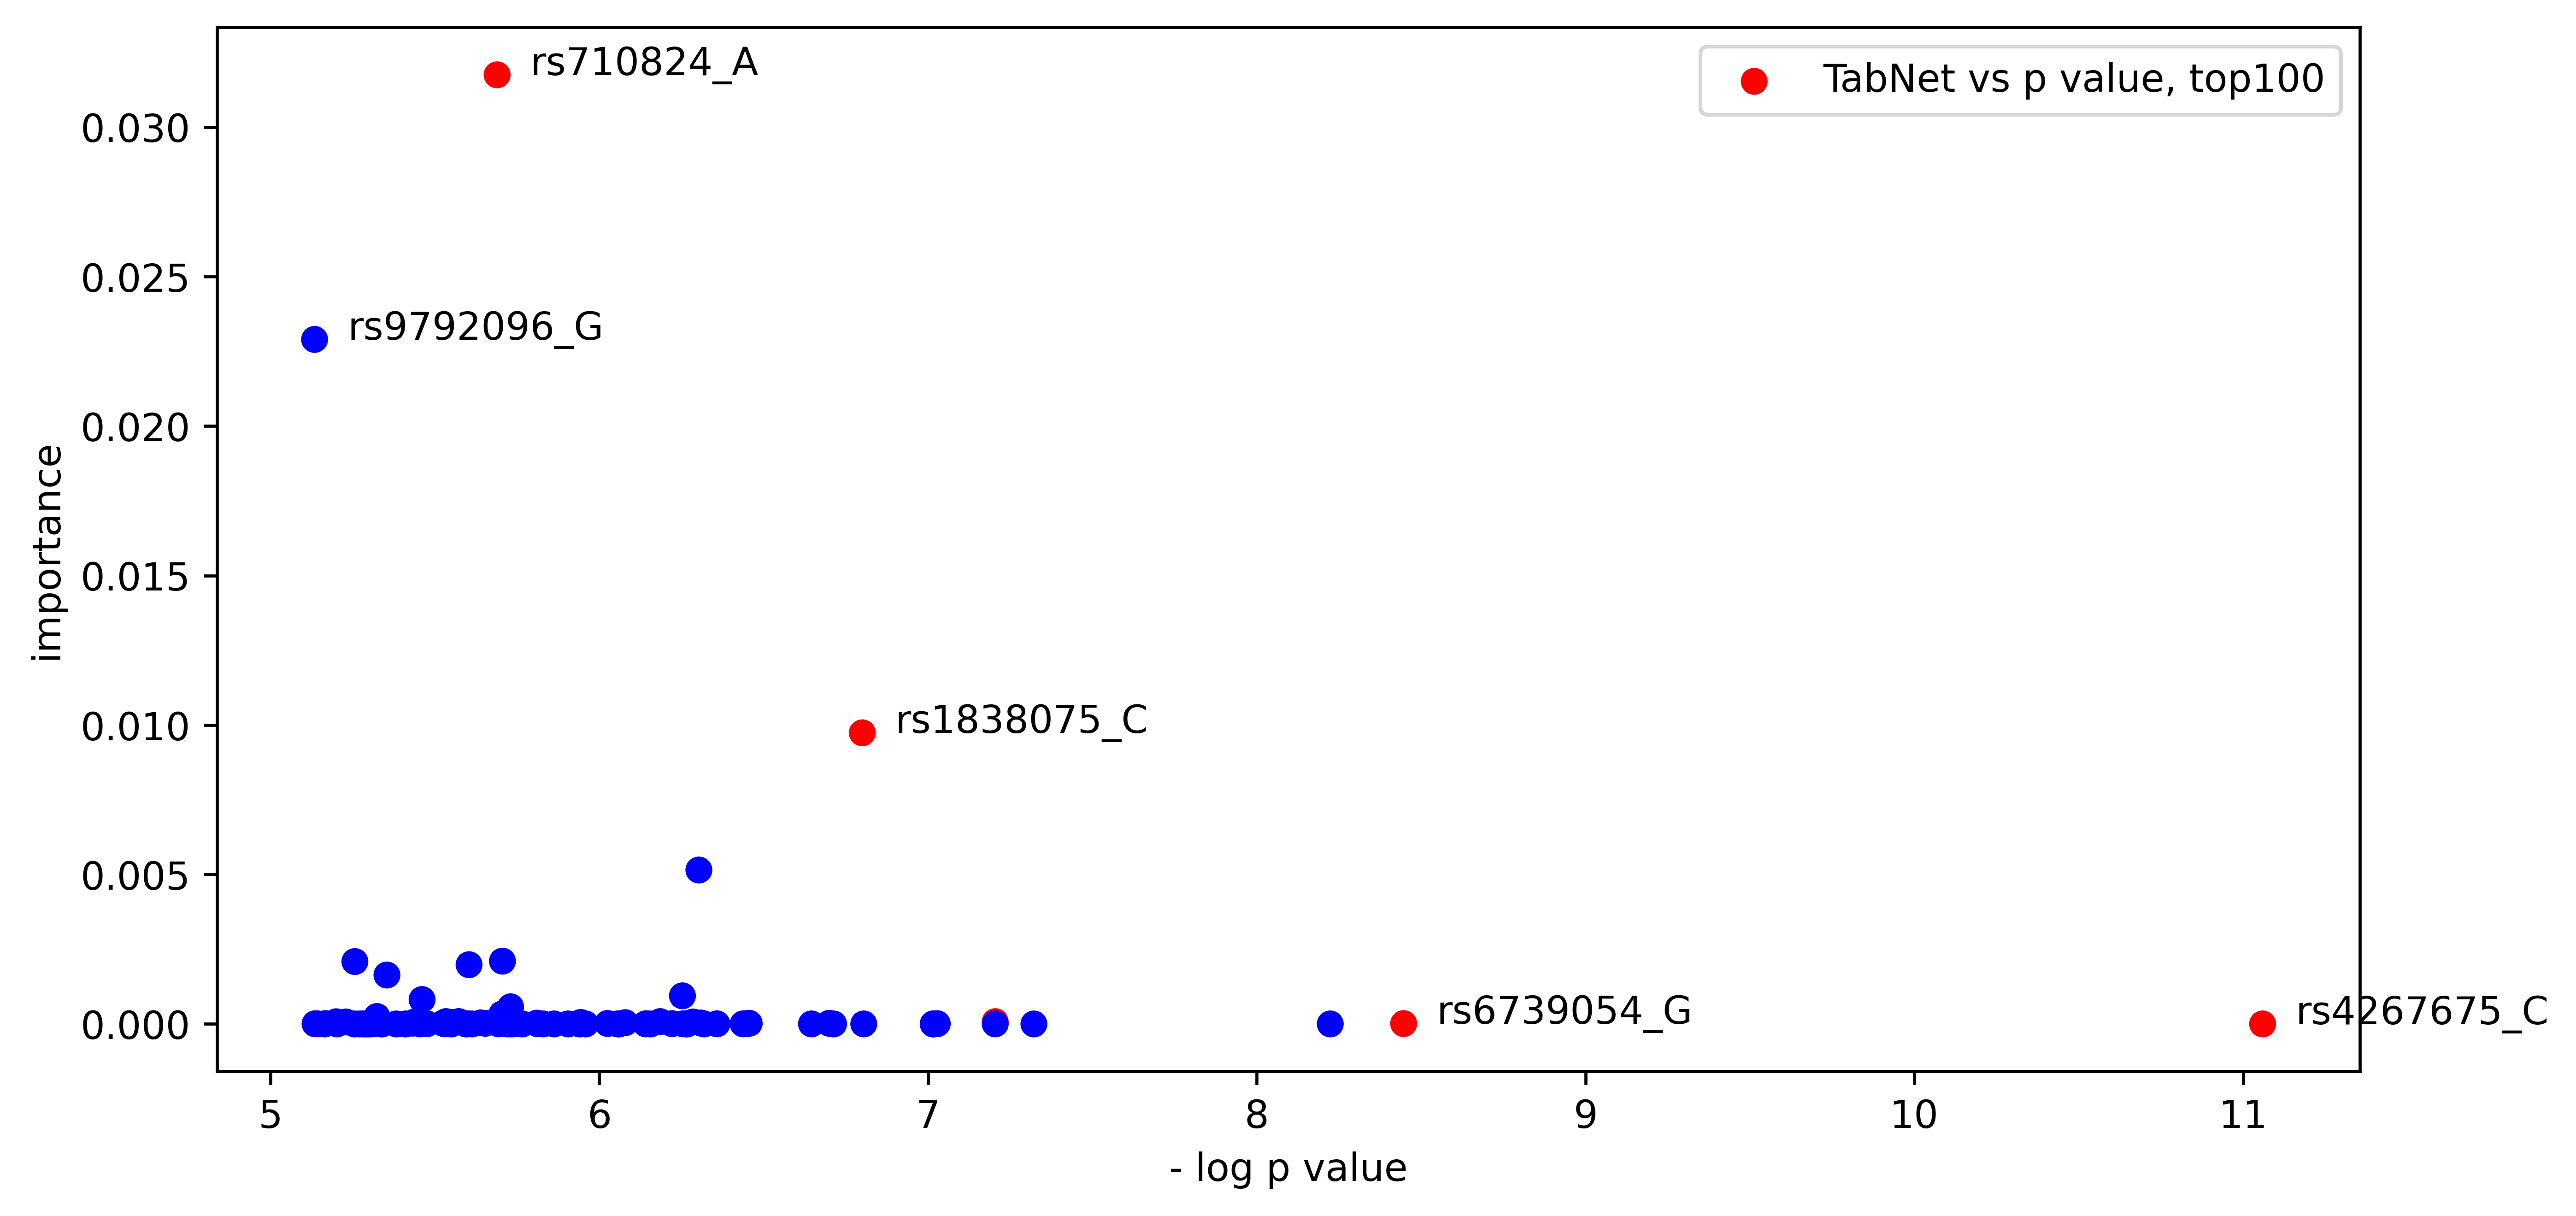

In [20]:
plt.figure(figsize=(10, 5), dpi=600)
df = t.sort_values(by='p value')[t['importance'] != 0][:100].reset_index()
x, y = df['log p value'], df['importance']

color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'


plt.scatter(x, y, color=color, label='TabNet vs p value, top100')
for i in range(100):
    if x[i] < 8.3 and y[i] < 0.007:
        continue
    if x[i] >= 5.5 or y[i] >= 0.0005:
        plt.annotate(df['snp'][i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

/home/stefan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


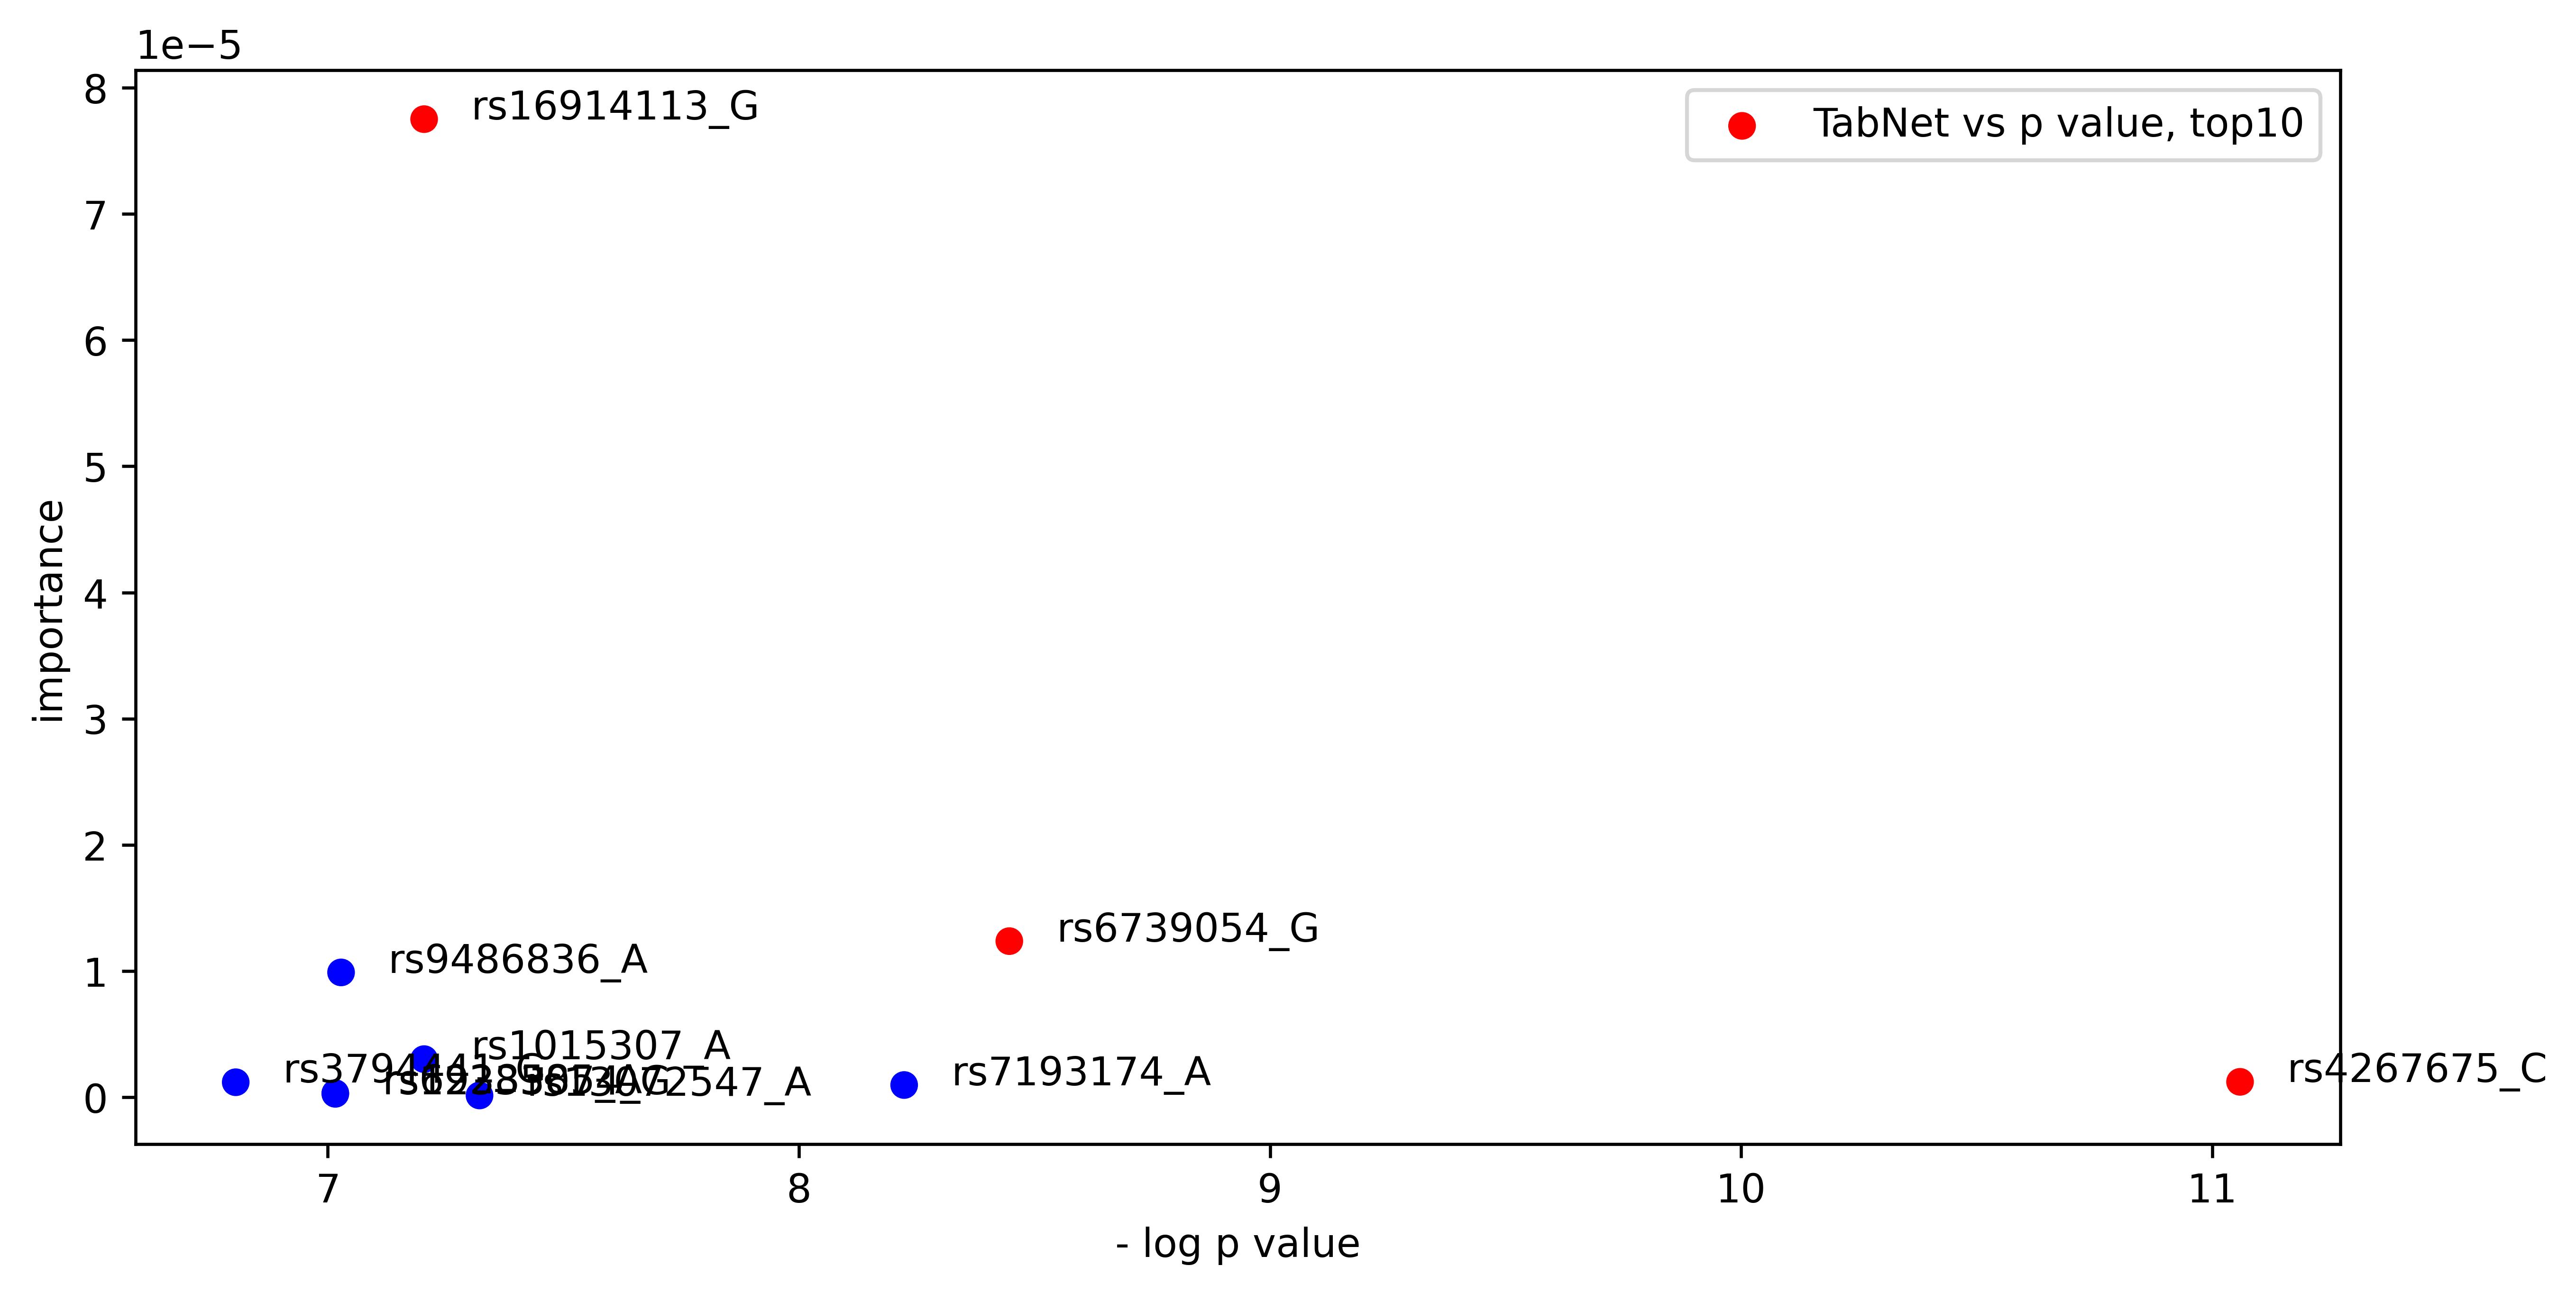

In [16]:
plt.figure(figsize=(10, 5), dpi=600)
df = t.sort_values(by='p value')[t['importance'] != 0][:10].reset_index()
x, y = df['log p value'], df['importance']

color = [None]*len(x)
for i, (a1, b1) in enumerate(zip(x, y)):
    for j, (a2, b2) in enumerate(zip(x, y)):
        if i != j and a2 >= a1 and b2 >= b1:
            color[i] = 'blue'
            break
    if color[i] is None:
        color[i] = 'red'


plt.scatter(x, y, color=color, label='TabNet vs p value, top10')
for i in range(10):
    plt.annotate(df['snp'][i], (x[i]+0.1, y[i]))
plt.xlabel('- log p value')
plt.ylabel('importance')
plt.legend()
plt.show()

In [101]:
pd.DataFrame({'SNP': snp_list, 'p value': p_values}).head(n=10).to_csv('GWAS_top10.csv', index=False)